<a href="https://colab.research.google.com/github/umairaziz719/SoundSense-Sentiment-Analysis/blob/main/soundsense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from typing_extensions import Annotated
import librosa.display
from tensorflow.keras import backend as K
from IPython.display import Audio
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D,MaxPool1D, Flatten,LSTM,BatchNormalization,Dense,Dropout, Activation, GRU
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,log_loss, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install librosa==0.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.2.post1
    Uninstalling librosa-0.10.2.post1:
      Successfully uninstalled librosa-0.10.2.post1


##Loading Data

In [3]:
drive.mount('/content/drive')
!git clone https://github.com/umairaziz719/SoundSense-Sentiment-Analysis.git
paths = []
labels = []
dataset_path = '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data'
directory_list = list(os.walk(dataset_path))
i = 0
while i < len(directory_list):
    directoryname, _, filenames = directory_list[i]
    j = 0
    while j < len(filenames):
        filename = filenames[j]
        file_path = os.path.join(directoryname, filename)
        paths.append(file_path)
        annotatedions = filename.split('_')[-1]
        annotatedions = annotatedions.split('.')[0]
        labels.append(annotatedions.lower())
        j += 1
    i += 1
print('Dataset is Loaded')

Mounted at /content/drive
Cloning into 'SoundSense-Sentiment-Analysis'...
remote: Enumerating objects: 2867, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 2867 (delta 18), reused 12 (delta 2), pack-reused 2818 (from 1)
Receiving objects: 100% (2867/2867), 221.43 MiB | 12.48 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (2802/2802), done.
Dataset is Loaded


In [39]:
len(paths)

2800

In [40]:
paths[:5]

['/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_lease_neutral.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_read_neutral.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_gap_neutral.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_turn_neutral.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_take_neutral.wav']

In [41]:
labels[:5]

['neutral', 'neutral', 'neutral', 'neutral', 'neutral']

##Exploratory Analysis

In [42]:
data = {'speech': paths, 'label': labels}
df = pd.DataFrame(data)
df.head()

,speech,label
0,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral
1,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral
2,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral
3,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral
4,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral


In [43]:
print("Data Types of DataFrame Columns:")
print(df.dtypes)

Data Types of DataFrame Columns:
speech    object
label     object
dtype: object


In [44]:
df['label'].value_counts()

,count
label,
neutral,400
sad,400
happy,400
fear,400
angry,400
ps,400
disgust,400


<Axes: xlabel='label', ylabel='count'>

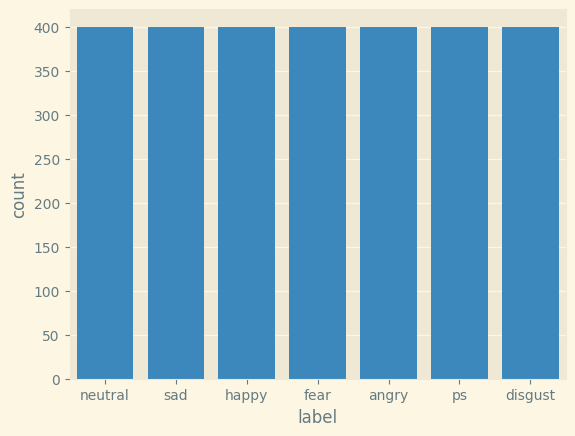

In [45]:
sns.countplot(data=df, x='label')

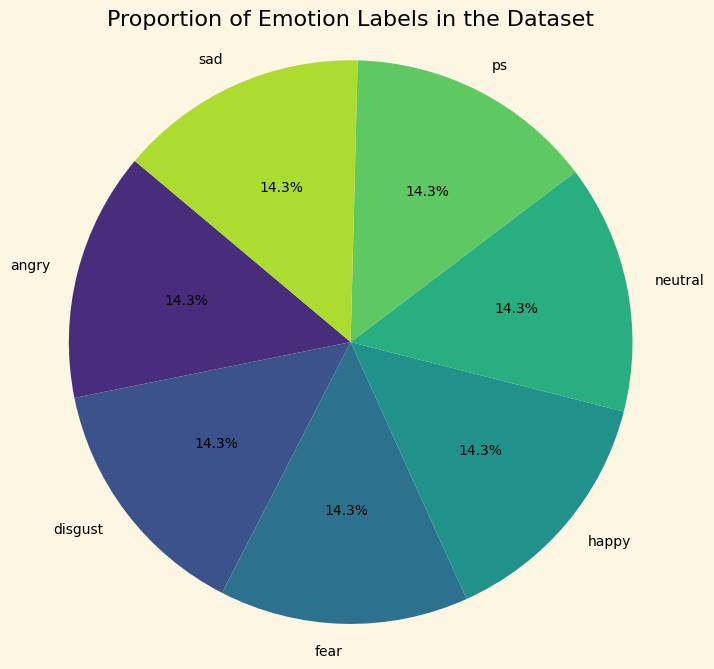

In [46]:
labels, counts = np.unique(df['label'], return_counts=True)
colors = sns.color_palette('viridis', len(labels))
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax.set_title('Proportion of Emotion Labels in the Dataset')
ax.axis('equal')
plt.show()

In [47]:
def plot_wave(emotion):
    plt.style.use('Solarize_Light2')
    path = df.loc[df['label'] == emotion, 'speech'].values[0]
    data, sampling_rate = librosa.load(path)
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    gs = fig.add_gridspec(2, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title(f'Waveform of {emotion}', fontsize=14, color='darkblue')
    ax1.fill_between(np.arange(len(data)), data, color='skyblue', alpha=0.5)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Amplitude', fontsize=12)
    ax2 = fig.add_subplot(gs[0, 1:])
    mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax2, cmap='coolwarm')
    ax2.set_title(f'MFCC of {emotion}', fontsize=14, color='darkred')
    fig.colorbar(img, ax=ax2)
    ax2.annotate(f'Mean MFCC: {np.mean(mfccs):.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='black', backgroundcolor='white')
    ax3 = fig.add_subplot(gs[1, :])
    zero_crossings = librosa.feature.zero_crossing_rate(data)[0]
    ax3.set_title(f'Zero Crossing Rate of {emotion}', fontsize=14, color='darkgreen')
    ax3.plot(zero_crossings, color='green')
    ax3.axhline(y=np.mean(zero_crossings), color='red', linestyle='--', label='Mean Rate')
    ax3.set_xlabel('Time', fontsize=12)
    ax3.set_ylabel('Rate', fontsize=12)
    ax3.legend(loc='upper right')

    plt.suptitle(f'Audio Analysis of {emotion}', fontsize=16, weight='bold')
    plt.show()

    return Audio(path)


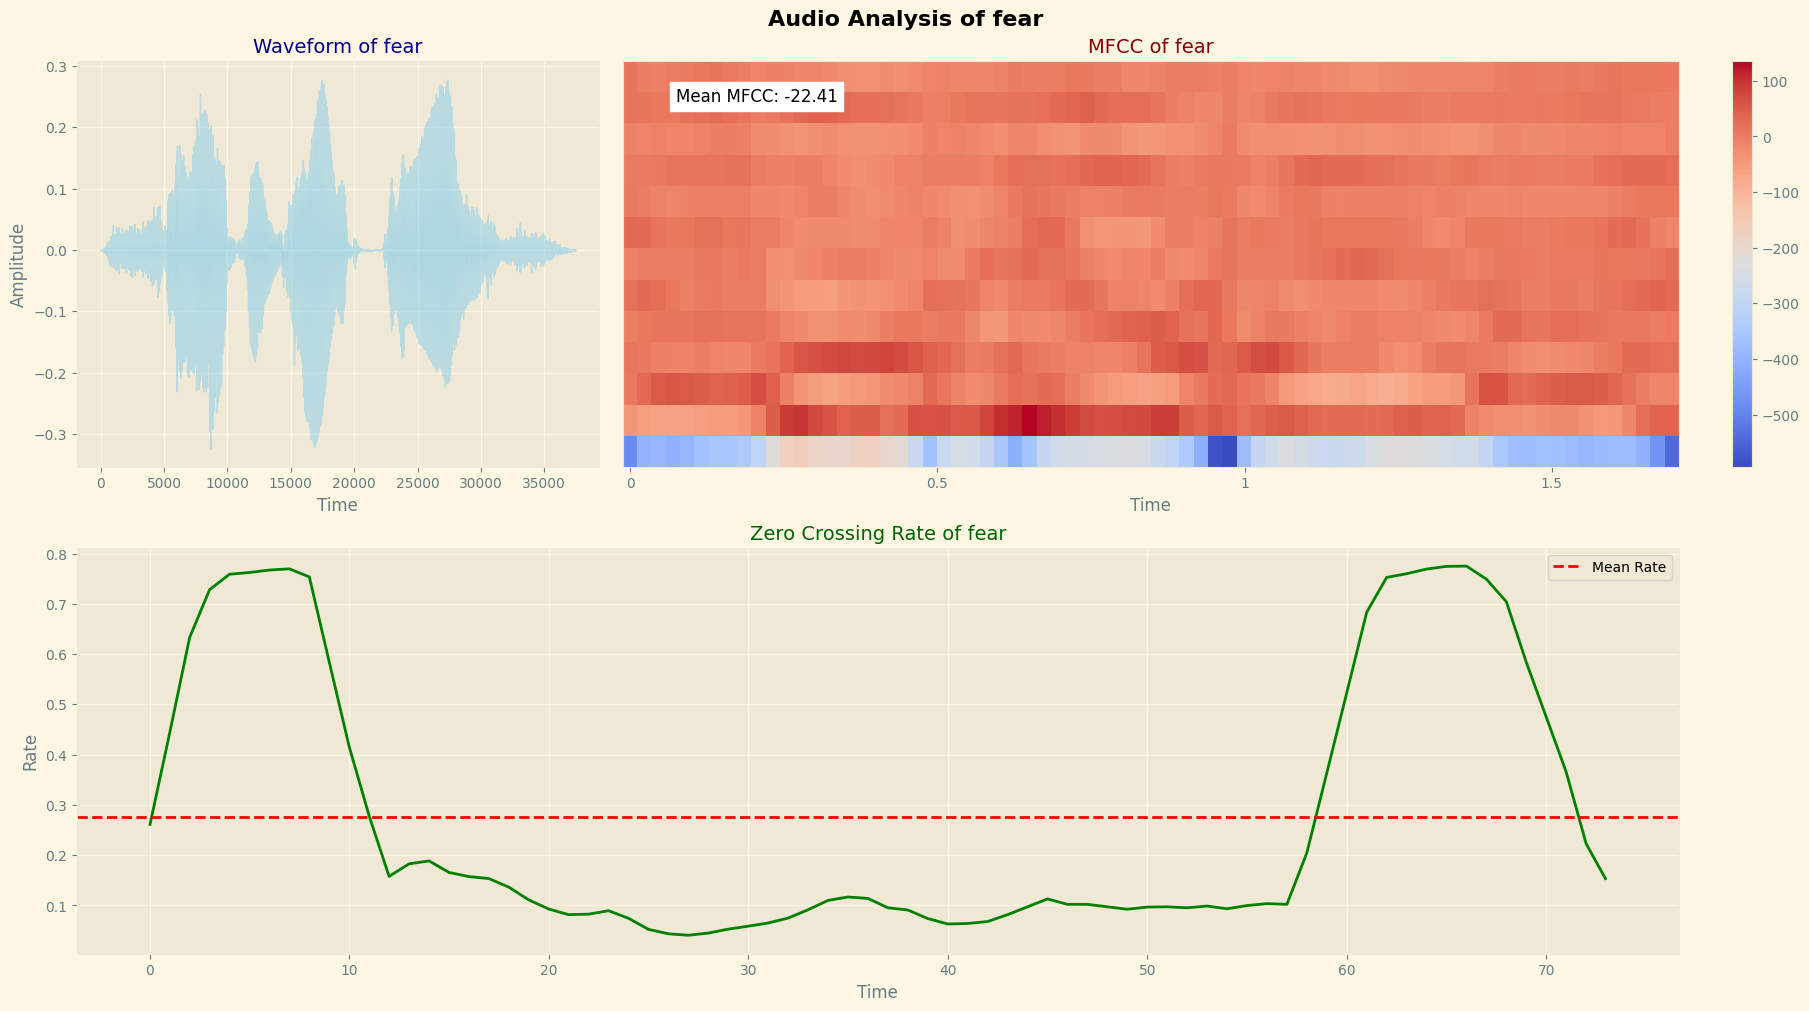

In [12]:
plot_wave('fear')

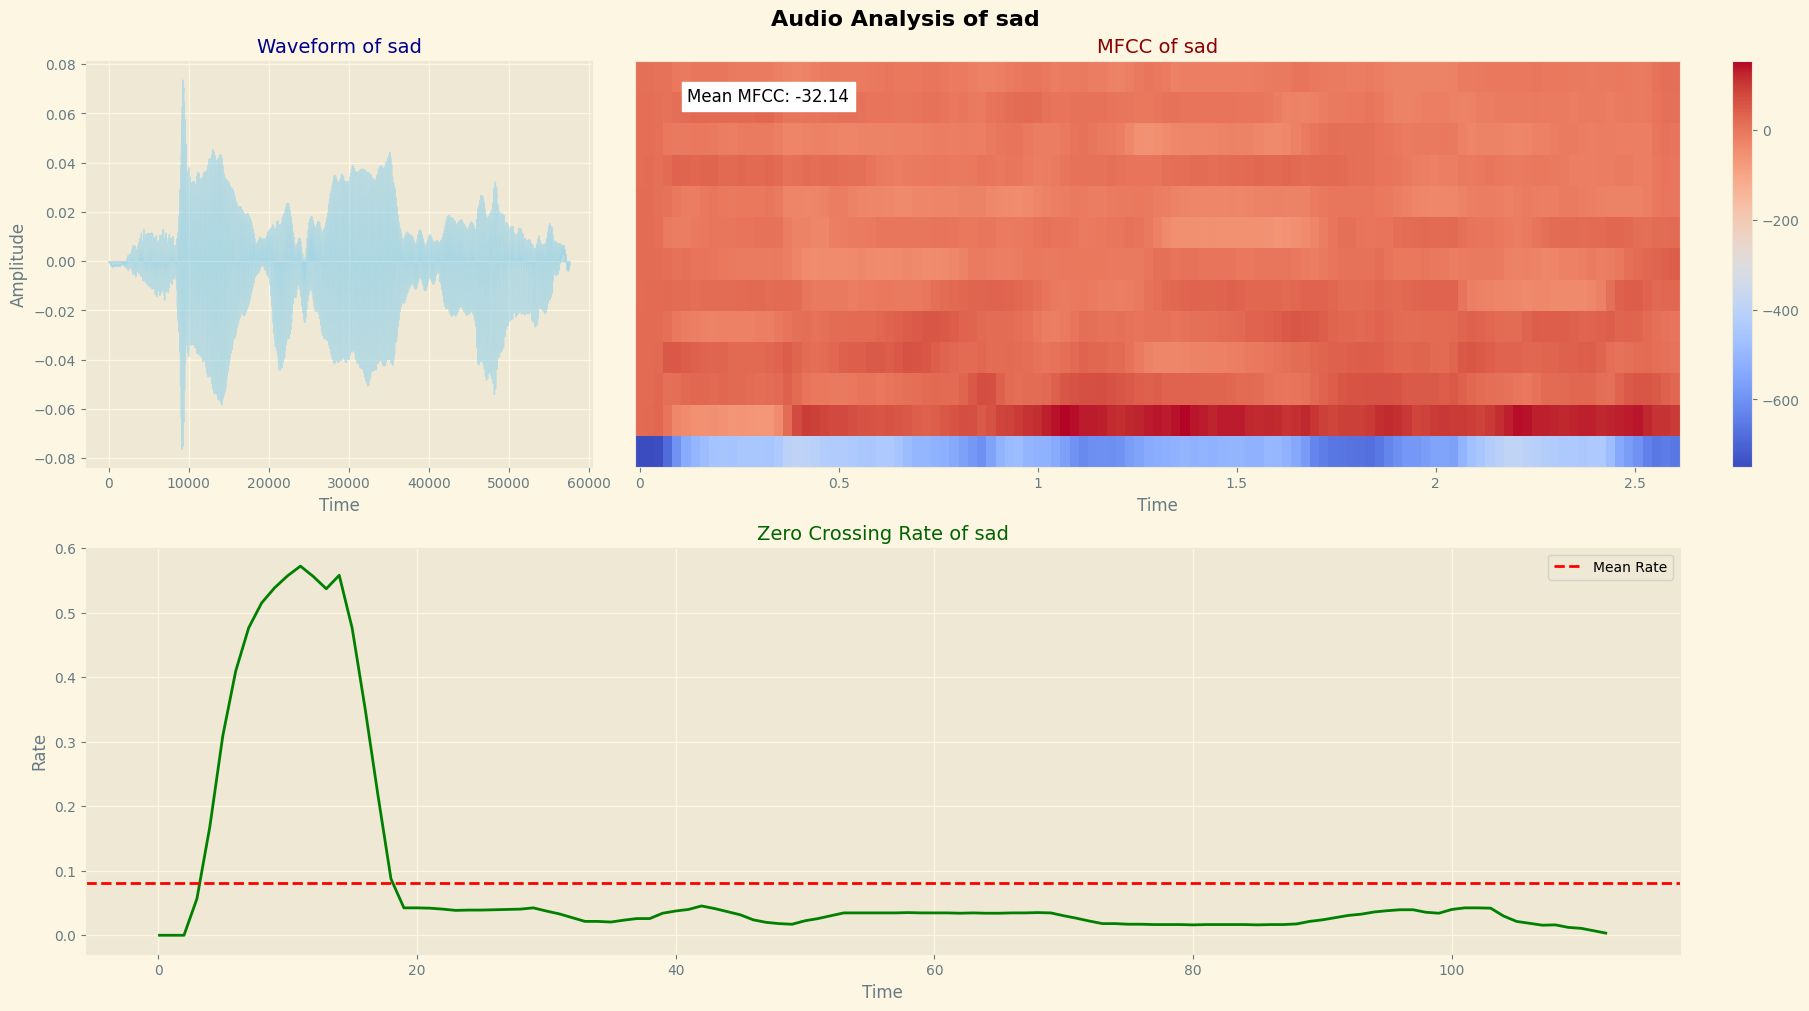

In [ ]:
plot_wave('sad')

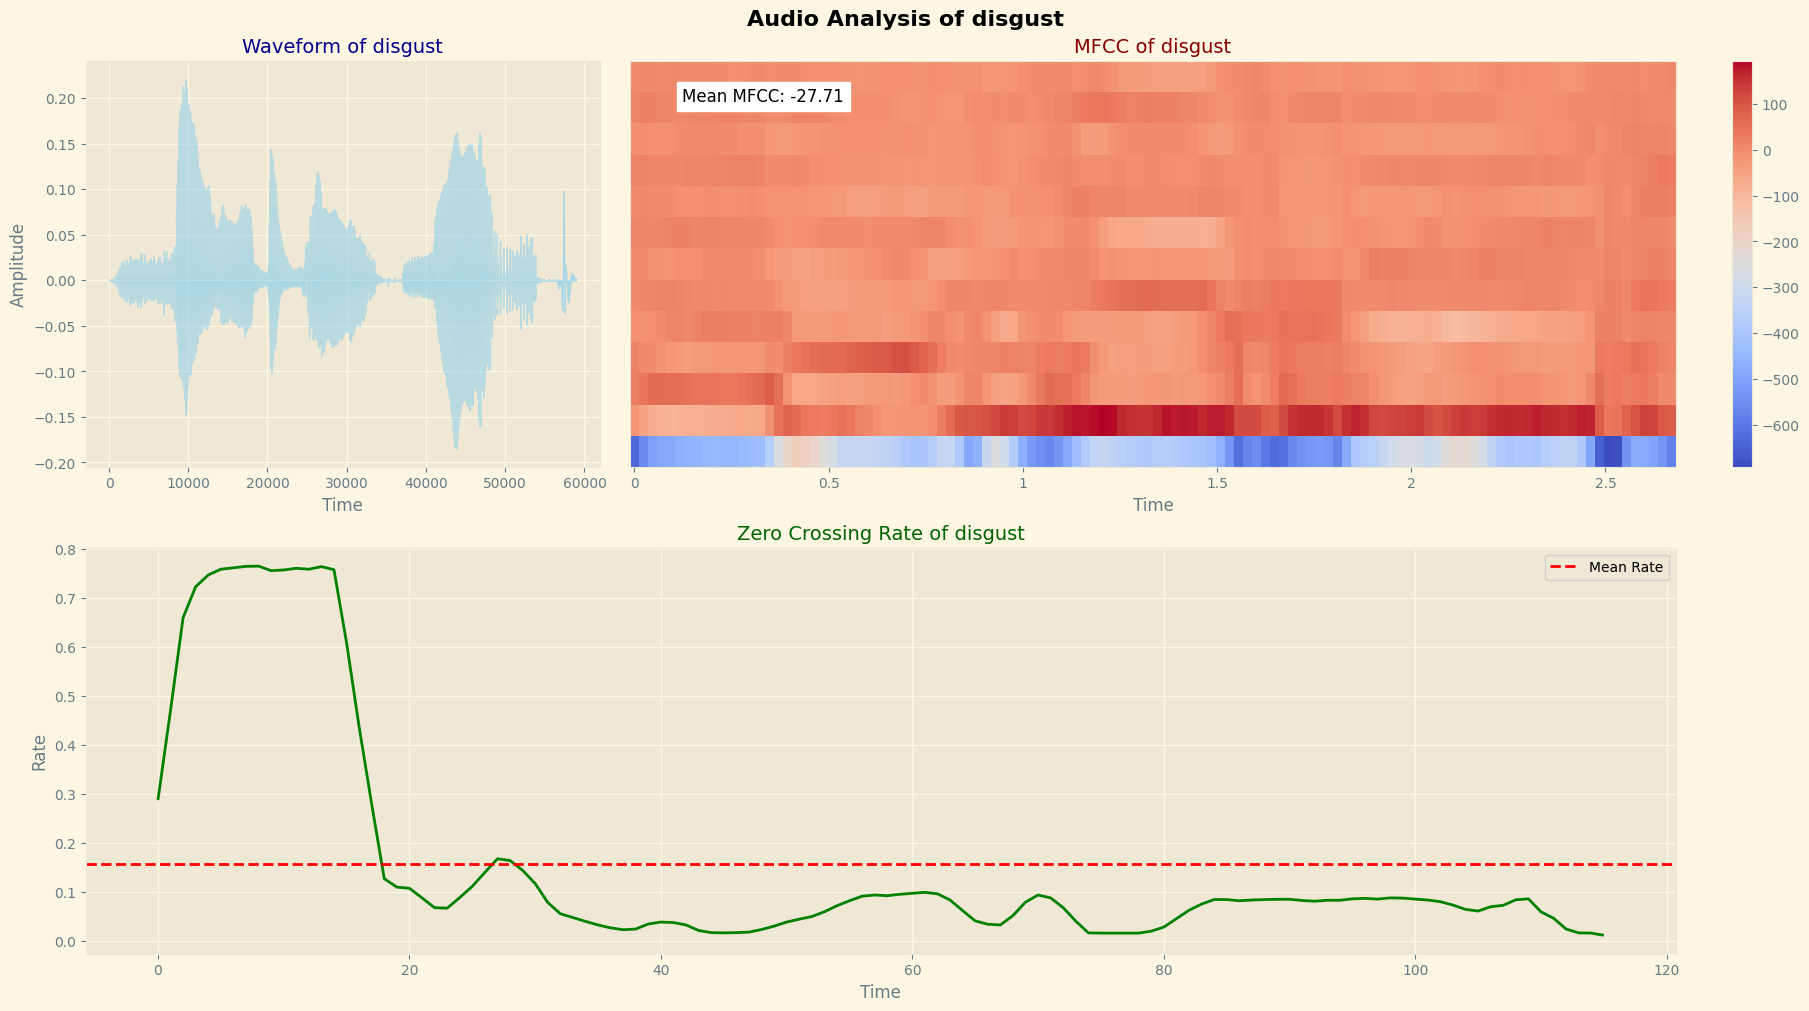

In [ ]:
plot_wave('disgust')

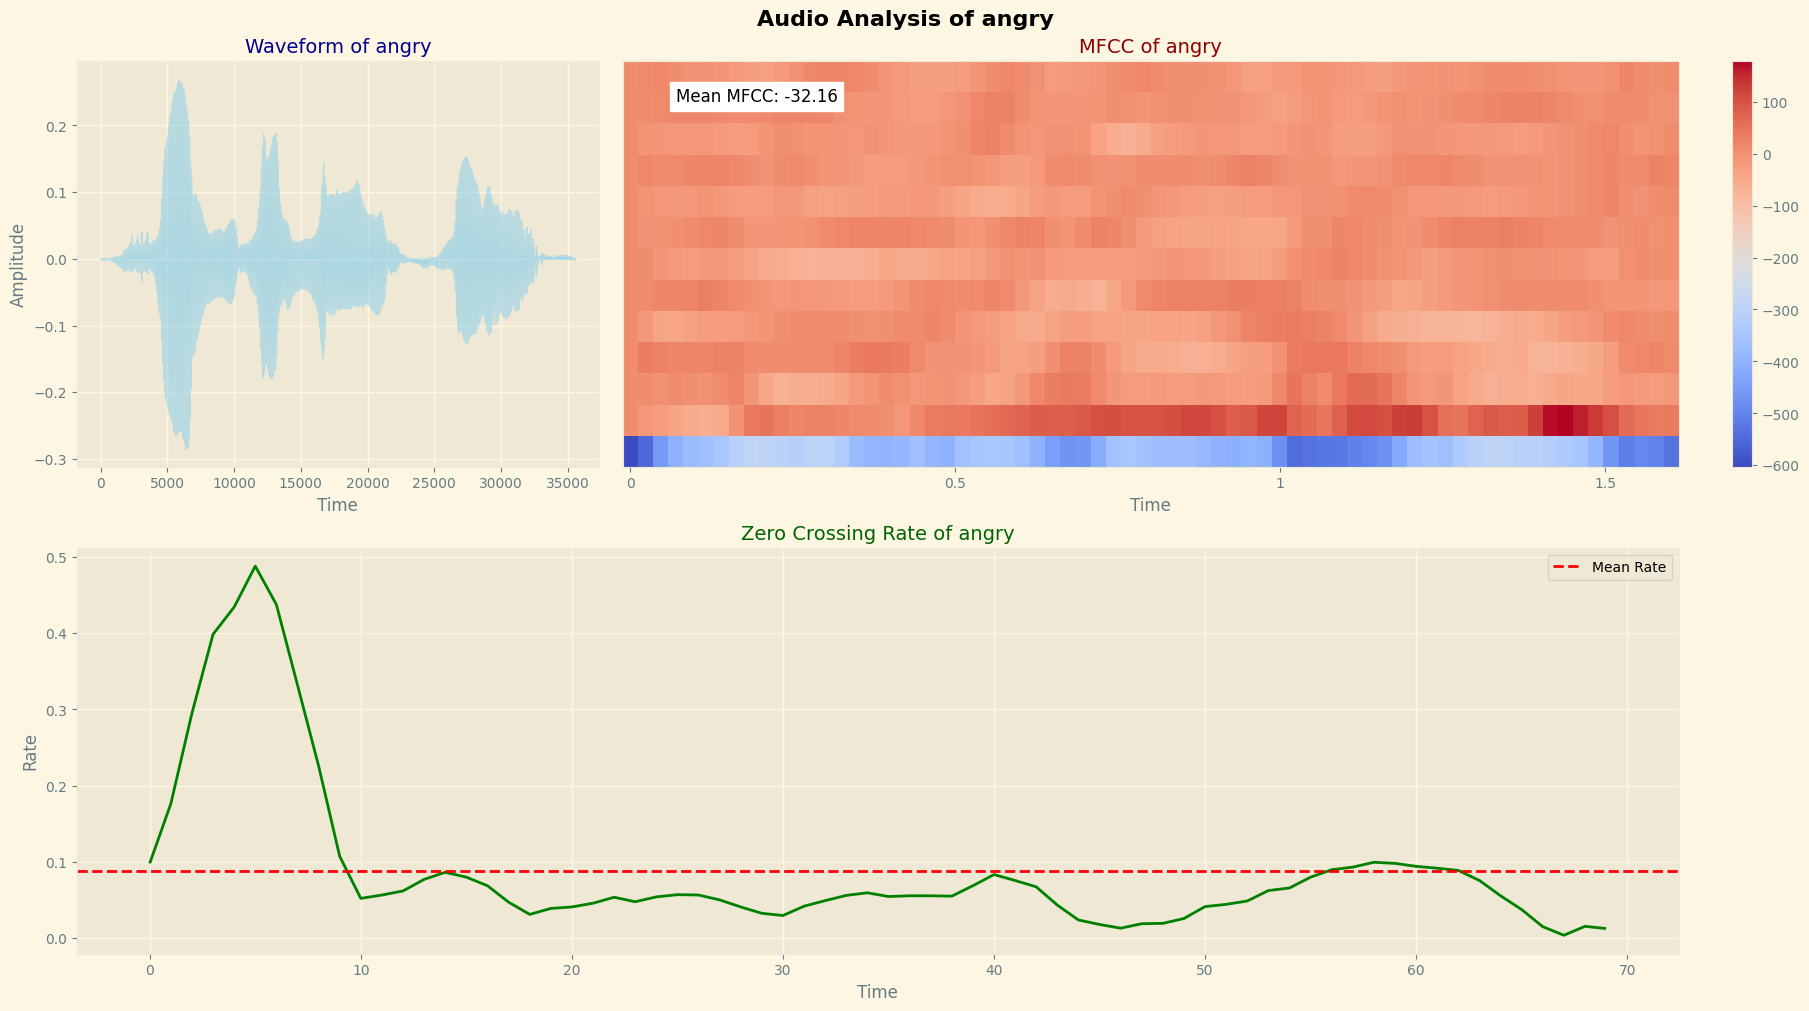

In [ ]:
plot_wave('angry')

##Data Agumentation Functions

In [48]:
class AudioProcessor:
    def __init__(self, file_path, duration=2.5, offset=0.6):
        self.audio_loc = file_path
        self.duration = duration
        self.offset = offset
        self.audio_raw, self.sample_rate = self.load_audio()

    def load_audio(self):
        return librosa.load(self.audio_loc, duration=self.duration, offset=self.offset)

    def extract_audio_features(self, audio_raw_data):
      extracted_attribute = []
      zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio_raw_data).T, axis=0)
      extracted_attribute.append(zero_crossing_rate)
      stft_out = np.abs(librosa.stft(audio_raw_data))
      chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=self.sample_rate).T, axis=0)
      extracted_attribute.append(chroma_stft)
      mfcc_out = np.mean(librosa.feature.mfcc(y=audio_raw_data, sr=self.sample_rate).T, axis=0)
      extracted_attribute.append(mfcc_out)
      root_mean_out = np.mean(librosa.feature.rms(y=audio_raw_data).T, axis=0)
      extracted_attribute.append(root_mean_out)
      mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=audio_raw_data, sr=self.sample_rate).T, axis=0)
      extracted_attribute.append(mel_spectrogram)
      output_result = np.hstack(extracted_attribute)
      return output_result

    def add_noise(self, data):
        value = 0.015 * np.random.uniform() * np.amax(data)
        return data + value * np.random.normal(size=data.shape[0])

    def add_stretch_process(self, data, rate=0.8):
        return librosa.effects.time_stretch(data, rate)

    def add_pitch_process(self, data, factor=0.7):
        return librosa.effects.pitch_shift(data, self.sample_rate,factor)

    def process_and_export_audio_features(self):
      results = []
      output_1 = self.extract_audio_features(self.audio_raw)
      results.append(output_1)
      noise_out = self.add_noise(self.audio_raw)
      output_2 = self.extract_audio_features(noise_out)
      results.append(output_2)
      stretched_out = self.add_stretch_process(self.audio_raw)
      stretched_pitch = self.add_pitch_process(stretched_out)
      output_3 = self.extract_audio_features(stretched_pitch)
      results.append(output_3)
      final_result = np.vstack(results)
      return final_result

In [49]:
class DataLoader:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.X_train = []
        self.y_train = []

    def load_data(self):
        for file_path, emotion_label in zip(self.dataframe['speech'], self.dataframe['label']):
            audio_processor = AudioProcessor(file_path)
            audio_features = audio_processor.process_and_export_audio_features()
            for feature_set in audio_features:
                self.X_train.append(feature_set)
                self.y_train.append(emotion_label)

        return np.array(self.X_train), np.array(self.y_train)


data_loader = DataLoader(df)
X_train, y_train = data_loader.load_data()


In [50]:
print(len(X_train))
print(len(y_train))
print(len(df['speech']))

8400
8400
2800


In [51]:
data = pd.DataFrame(X_train)
data["speech"] = y_train

In [17]:
data.head(-1)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,speech
0,0.172903,0.395455,0.436142,0.553351,0.324764,0.238452,0.331945,0.537621,0.854643,0.594637,...,0.003627,0.004502,0.003027,0.001672,0.002270,0.001536,0.000288,2.886469e-05,4.877137e-07,neutral
1,0.223217,0.436708,0.473698,0.619787,0.426631,0.327742,0.368562,0.535805,0.849919,0.636132,...,0.003764,0.004609,0.003109,0.001751,0.002485,0.001716,0.000435,1.697529e-04,1.520441e-04,neutral
2,0.183431,0.419990,0.380882,0.409297,0.469405,0.243492,0.213145,0.317116,0.573197,0.835241,...,0.000441,0.000506,0.000882,0.000579,0.000413,0.000182,0.000079,6.314851e-06,1.040353e-08,neutral
3,0.050182,0.280028,0.346135,0.576326,0.355023,0.276299,0.347985,0.546843,0.947266,0.603876,...,0.000014,0.000015,0.000024,0.000037,0.000050,0.000019,0.000002,2.252871e-07,4.705535e-09,neutral
4,0.076867,0.304878,0.371705,0.595124,0.372309,0.328695,0.380161,0.566700,0.943543,0.581153,...,0.000038,0.000038,0.000053,0.000068,0.000076,0.000047,0.000030,2.558551e-05,2.675618e-05,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,0.048926,0.548668,0.754922,0.496758,0.326069,0.302827,0.323741,0.279682,0.384729,0.468250,...,0.000119,0.000191,0.000142,0.000074,0.000046,0.000023,0.000009,8.326342e-07,5.784197e-08,angry
8395,0.072917,0.571116,0.786036,0.552977,0.405115,0.362795,0.346184,0.307237,0.397978,0.467417,...,0.000166,0.000244,0.000201,0.000135,0.000098,0.000077,0.000065,5.597383e-05,5.746594e-05,angry
8396,0.053865,0.463684,0.564289,0.794833,0.509397,0.322398,0.262082,0.296280,0.234812,0.338391,...,0.000054,0.000035,0.000050,0.000045,0.000024,0.000008,0.000001,1.473743e-07,3.159590e-08,angry
8397,0.161768,0.613019,0.671028,0.490004,0.484295,0.497958,0.498792,0.435124,0.499023,0.526624,...,0.001285,0.001710,0.000855,0.000910,0.000826,0.000692,0.000131,9.947793e-06,2.715640e-07,angry


In [52]:
print(data["speech"].value_counts())

speech
neutral    1200
sad        1200
happy      1200
fear       1200
angry      1200
ps         1200
disgust    1200
Name: count, dtype: int64


##Preprocessing

In [53]:
class DataPreprocessor:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.encoder = OneHotEncoder(sparse=False)
        self.scaler = StandardScaler()

    def prepare_data(self):
        Y = self.encoder.fit_transform(self.y_train.reshape(-1, 1))
        X_train, X_val, y_train, y_val = train_test_split(self.X_train, Y, train_size=0.8, random_state=42, shuffle=True)
        n_features = X_train.shape[1]
        X_train = self.scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(X_train.shape)
        X_val = self.scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape)
        X_train = np.expand_dims(X_train, axis=2)
        X_val = np.expand_dims(X_val, axis=2)
        return X_train, X_val, y_train, y_val


In [20]:
preprocessor = DataPreprocessor(X_train, y_train)
X_train, X_val, y_train, y_val = preprocessor.prepare_data()
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(6720, 162, 1) (1680, 162, 1) (6720, 7) (1680, 7)


##CNN Model

In [ ]:
model = tf.keras.Sequential([
    Conv1D(512, kernel_regularizer=tf.keras.regularizers.l2(0.01),input_shape=(X_train.shape[1], 1),kernel_size=5, strides=1, padding='same', activation='relu'
             ),
    BatchNormalization(),
    MaxPool1D(padding='same', strides=2,pool_size=5),
    Dropout(0.25),

    Conv1D(256,
             kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu',  strides=1, padding='same',kernel_size=5),
    BatchNormalization(),
    MaxPool1D(padding='same',strides=2,pool_size=5),
    Dropout(0.25),

    Conv1D(128,
             kernel_regularizer=tf.keras.regularizers.l2(0.01), strides=1, padding='same', activation='relu', kernel_size=5),
    BatchNormalization(),
    MaxPool1D( strides=2, padding='same',pool_size=5),
    Dropout(0.25),

    Conv1D(128, kernel_size=3, strides=1,
             kernel_regularizer=tf.keras.regularizers.l2(0.01) ,padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.25),

    Conv1D(64, kernel_size=3, strides=1, padding='same',
             kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.25),

    Flatten(),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00075, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 162, 512)          3072      
                                                                 
 batch_normalization_49 (Ba  (None, 162, 512)          2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 81, 512)           0         
 ng1D)                                                           
                                                                 
 dropout_49 (Dropout)        (None, 81, 512)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 81, 256)           655616    
                                                                 
 batch_normalization_50 (Ba  (None, 81, 256)         

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.4,min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/35
105/105 [==============================] - 12s 84ms/step - loss: 10.9911 - accuracy: 0.4363 - val_loss: 9.5158 - val_accuracy: 0.2548 - lr: 7.5000e-04
Epoch 2/35
105/105 [==============================] - 8s 77ms/step - loss: 6.6634 - accuracy: 0.7829 - val_loss: 6.7471 - val_accuracy: 0.2446 - lr: 7.5000e-04
Epoch 3/35
105/105 [==============================] - 8s 77ms/step - loss: 4.1538 - accuracy: 0.8713 - val_loss: 4.5455 - val_accuracy: 0.3857 - lr: 7.5000e-04
Epoch 4/35
105/105 [==============================] - 8s 77ms/step - loss: 2.7801 - accuracy: 0.8958 - val_loss: 3.6057 - val_accuracy: 0.3155 - lr: 7.5000e-04
Epoch 5/35
105/105 [==============================] - 8s 79ms/step - loss: 1.9640 - accuracy: 0.9170 - val_loss: 2.2191 - val_accuracy: 0.7577 - lr: 7.5000e-04
Epoch 6/35
105/105 [==============================] - 8s 79ms/step - loss: 1.5219 - accuracy: 0.9185 - val_loss: 1.7613 - val_accuracy: 0.8262 - lr: 7.5000e-04
Epoch 7/35
105/105 [==================

In [ ]:
data = pd.DataFrame({
    'Epoch': list(range(len(history.history['loss']))),
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})
data_melted = data.melt(id_vars='Epoch', var_name='Loss Type', value_name='Loss')
chart = alt.Chart(data_melted).mark_line(point=True).encode(
    x='Epoch:O',
    y='Loss:Q',
    color='Loss Type:N',
    tooltip=['Epoch', 'Loss Type', 'Loss']
).properties(
    title='Model Loss Over Epochs'
)
chart.display()


alt.Chart(...)

In [ ]:
data = pd.DataFrame({
    'Epoch': list(range(len(history.history['accuracy']))),
    'Training Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy']
})
data_melted = data.melt(id_vars='Epoch', var_name='Accuracy Type', value_name='Accuracy')
chart = alt.Chart(data_melted).mark_line(point=True).encode(
    x='Epoch:O',
    y='Accuracy:Q',
    color='Accuracy Type:N',
    tooltip=['Epoch', 'Accuracy Type', 'Accuracy']
).properties(
    title='Model Accuracy Over Epochs'
)
chart.display()

alt.Chart(...)

In [ ]:
sample_size = 100
y_pred = model.predict(X_val[:sample_size])
y_pred_labels = preprocessor.encoder.inverse_transform(y_pred)
y_val_labels = preprocessor.encoder.inverse_transform(y_val[:sample_size])

df = pd.DataFrame({
    'Predicted Labels': y_pred_labels.flatten(),
    'Actual Labels': y_val_labels.flatten()
})

print(df)

4/4 [==============================] - 0s 11ms/step
   Predicted Labels Actual Labels
0               sad           sad
1                ps            ps
2                ps            ps
3             angry         angry
4              fear          fear
..              ...           ...
95          disgust       disgust
96          disgust       disgust
97            angry         angry
98          neutral       neutral
99               ps            ps

[100 rows x 2 columns]


In [ ]:
c_matrix = confusion_matrix(y_val_labels, y_pred_labels)
labels = np.unique(np.concatenate((y_val_labels, y_pred_labels)))
print("Confusion matrix shape:", c_matrix.shape)
print("Labels length:", len(labels))
if c_matrix.shape[0] != len(labels) or c_matrix.shape[1] != len(labels):
    raise ValueError("Mismatch between labels and confusion matrix dimensions")
c_matrix_df = pd.DataFrame(c_matrix, index=labels, columns=labels).reset_index().melt(id_vars='index')
c_matrix_df.columns = ['True Label', 'Predicted Label', 'Count']
heatmap = alt.Chart(c_matrix_df).mark_rect().encode(
    x=alt.X('Predicted Label:O', title='Predicted Labels'),
    y=alt.Y('True Label:O', title='True Labels'),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
    tooltip=['True Label', 'Predicted Label', 'Count']
).properties(
    width=400,
    height=400,
    title='Confusion Matrix'
)
text = heatmap.mark_text(align='center', baseline='middle').encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > c_matrix_df['Count'].mean(),  # Conditional color for text
        alt.value('black'),
        alt.value('black')
    )
)
final_plot = heatmap + text
final_plot.display()

Confusion matrix shape: (7, 7)
Labels length: 7


alt.LayerChart(...)

##LSTM model

In [ ]:

model1 = Sequential([
    LSTM(128, kernel_regularizer=l2(0.001), recurrent_dropout=0.2, return_sequences=True,
         kernel_constraint=MaxNorm(3), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(64, kernel_regularizer=l2(0.001), recurrent_dropout=0.2, return_sequences=True),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(32, kernel_regularizer=l2(0.001), return_sequences=True),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(7, activation='softmax')
])

optimizer = Adam(
    weight_decay=0.01,
    clipnorm=1
)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 162, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 162, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 162, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 162, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 162, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 162, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 162, 32)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 162, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 162, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,367 (560.03 KB)

 Trainable params: 142,599 (557.03 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=4,
    verbose=1,
    mode='min',
    min_lr=1e-9
)

In [ ]:
history1 = model1.fit(X_train, y_train,
                      epochs=35,
                      batch_size=128,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/35
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.1810 - loss: 2.5373
Epoch 1: val_accuracy improved from -inf to 0.17024, saving model to best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1813 - loss: 2.5347 - val_accuracy: 0.1702 - val_loss: 2.2411 - learning_rate: 0.0010
Epoch 2/35
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.2173 - loss: 2.2260
Epoch 2: val_accuracy did not improve from 0.17024
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2173 - loss: 2.2256 - val_accuracy: 0.1673 - val_loss: 2.2013 - learning_rate: 0.0010
Epoch 3/35
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.2298 - loss: 2.1451
Epoch 3: val_accuracy improved from 0.17024 to 0.17083, saving model to best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2298 - loss: 2.1452 - val_accuracy: 0.1708 - val_loss: 2.1764 - learning_rate: 0.0010
Epoch 4/35
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.2334 - loss: 2.0902
Epoch 4: val_

In [ ]:
data = pd.DataFrame({
    'Epoch': list(range(len(history1.history['loss']))),
    'Training Loss': history1.history['loss'],
    'Validation Loss': history1.history['val_loss']
})
data_melted = data.melt(id_vars='Epoch', var_name='Loss Type', value_name='Loss')
chart = alt.Chart(data_melted).mark_line(point=True).encode(
    x='Epoch:O',
    y='Loss:Q',
    color='Loss Type:N',
    tooltip=['Epoch', 'Loss Type', 'Loss']
).properties(
    title='Model Loss Over Epochs'
)
chart.display()


alt.Chart(...)

In [ ]:
data = pd.DataFrame({
    'Epoch': list(range(len(history1.history['accuracy']))),
    'Training Accuracy': history1.history['accuracy'],
    'Validation Accuracy': history1.history['val_accuracy']
})
data_melted = data.melt(id_vars='Epoch', var_name='Accuracy Type', value_name='Accuracy')
chart = alt.Chart(data_melted).mark_line(point=True).encode(
    x='Epoch:O',
    y='Accuracy:Q',
    color='Accuracy Type:N',
    tooltip=['Epoch', 'Accuracy Type', 'Accuracy']
).properties(
    title='Model Accuracy Over Epochs'
)
chart.display()

alt.Chart(...)

In [ ]:
sample_size = 100
y_pred = model1.predict(X_val[:sample_size])
y_pred_labels = preprocessor.encoder.inverse_transform(y_pred)
y_val_labels = preprocessor.encoder.inverse_transform(y_val[:sample_size])

df = pd.DataFrame({
    'Predicted Labels': y_pred_labels.flatten(),
    'Actual Labels': y_val_labels.flatten()
})

print(df)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 724ms/step
   Predicted Labels Actual Labels
0               sad           sad
1                ps            ps
2           disgust            ps
3              fear          fear
4           neutral       neutral
..              ...           ...
95               ps         happy
96               ps         happy
97            happy          fear
98          neutral         angry
99               ps            ps

[100 rows x 2 columns]


In [ ]:
c_matrix = confusion_matrix(y_val_labels, y_pred_labels)
labels = np.unique(np.concatenate((y_val_labels, y_pred_labels)))
print("Confusion matrix shape:", c_matrix.shape)
print("Labels length:", len(labels))
if c_matrix.shape[0] != len(labels) or c_matrix.shape[1] != len(labels):
    raise ValueError("Mismatch between labels and confusion matrix dimensions")
c_matrix_df = pd.DataFrame(c_matrix, index=labels, columns=labels).reset_index().melt(id_vars='index')
c_matrix_df.columns = ['True Label', 'Predicted Label', 'Count']
heatmap = alt.Chart(c_matrix_df).mark_rect().encode(
    x=alt.X('Predicted Label:O', title='Predicted Labels'),
    y=alt.Y('True Label:O', title='True Labels'),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
    tooltip=['True Label', 'Predicted Label', 'Count']).properties(
    width=400,
    height=400,
    title='Confusion Matrix')
text = heatmap.mark_text(align='center', baseline='middle').encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > c_matrix_df['Count'].mean(),
        alt.value('black'),
        alt.value('black')))
final_plot = heatmap + text
final_plot.display()

Confusion matrix shape: (7, 7)
Labels length: 7


alt.LayerChart(...)

##GRU Model

In [28]:
model2 = Sequential([
    GRU(256,  kernel_regularizer=tf.keras.regularizers.l2(0.02),return_sequences=True, input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.5),
    GRU(128,kernel_regularizer=tf.keras.regularizers.l2(0.02),return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    GRU(64, kernel_regularizer=tf.keras.regularizers.l2(0.02),return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.02), activation='relu'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(7, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(weight_decay=1e-4, clipnorm=1)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 162, 256)          198912    
                                                                 
 batch_normalization_12 (Ba  (None, 162, 256)          1024      
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 162, 256)          0         
                                                                 
 gru_10 (GRU)                (None, 162, 128)          148224    
                                                                 
 batch_normalization_13 (Ba  (None, 162, 128)          512       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 162, 128)         

In [29]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_scheduler=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

In [30]:
history2 = model2.fit(X_train, y_train,epochs = 35,validation_data=(X_val, y_val), batch_size = 64, shuffle = True,callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/35
105/105 [==============================] - 62s 533ms/step - loss: 10.6260 - accuracy: 0.1708 - val_loss: 7.0880 - val_accuracy: 0.1405 - lr: 0.0010
Epoch 2/35
105/105 [==============================] - 54s 515ms/step - loss: 6.3955 - accuracy: 0.1751 - val_loss: 4.9115 - val_accuracy: 0.1714 - lr: 0.0010
Epoch 3/35
105/105 [==============================] - 54s 519ms/step - loss: 4.6668 - accuracy: 0.1882 - val_loss: 3.9572 - val_accuracy: 0.1387 - lr: 0.0010
Epoch 4/35
105/105 [==============================] - 54s 513ms/step - loss: 3.6033 - accuracy: 0.2101 - val_loss: 3.1012 - val_accuracy: 0.2476 - lr: 0.0010
Epoch 5/35
105/105 [==============================] - 54s 518ms/step - loss: 2.5820 - accuracy: 0.3525 - val_loss: 2.9205 - val_accuracy: 0.1446 - lr: 0.0010
Epoch 6/35
105/105 [==============================] - 54s 516ms/step - loss: 1.7447 - accuracy: 0.5452 - val_loss: 2.7160 - val_accuracy: 0.2226 - lr: 0.0010
Epoch 7/35
105/105 [==============================]

In [31]:
data = pd.DataFrame({
    'Epoch': list(range(len(history2.history['loss']))),
    'Training Loss': history2.history['loss'],
    'Validation Loss': history2.history['val_loss']
})
data_melted = data.melt(id_vars='Epoch', var_name='Loss Type', value_name='Loss')
chart = alt.Chart(data_melted).mark_line(point=True).encode(
    x='Epoch:O',
    y='Loss:Q',
    color='Loss Type:N',
    tooltip=['Epoch', 'Loss Type', 'Loss']
).properties(
    title='Model Loss Over Epochs'
)
chart.display()

alt.Chart(...)

In [32]:
data = pd.DataFrame({
    'Epoch': list(range(len(history2.history['accuracy']))),
    'Training Accuracy': history2.history['accuracy'],
    'Validation Accuracy': history2.history['val_accuracy']
})
data_melted = data.melt(id_vars='Epoch', var_name='Accuracy Type', value_name='Accuracy')
chart = alt.Chart(data_melted).mark_line(point=True).encode(
    x='Epoch:O',
    y='Accuracy:Q',
    color='Accuracy Type:N',
    tooltip=['Epoch', 'Accuracy Type', 'Accuracy']
).properties(
    title='Model Accuracy Over Epochs'
)
chart.display()

alt.Chart(...)

In [33]:
sample_size = 100
y_pred = model2.predict(X_val[:sample_size])
y_pred_labels = preprocessor.encoder.inverse_transform(y_pred)
y_val_labels = preprocessor.encoder.inverse_transform(y_val[:sample_size])
df = pd.DataFrame({
    'Predicted Labels': y_pred_labels.flatten(),
    'Actual Labels': y_val_labels.flatten()})
print(df)

4/4 [==============================] - 1s 92ms/step
   Predicted Labels Actual Labels
0           neutral       neutral
1                ps            ps
2                ps            ps
3                ps            ps
4           neutral       neutral
..              ...           ...
95          disgust       disgust
96          disgust       disgust
97               ps            ps
98              sad           sad
99               ps            ps

[100 rows x 2 columns]


In [34]:
c_matrix = confusion_matrix(y_val_labels, y_pred_labels)
labels = np.unique(np.concatenate((y_val_labels, y_pred_labels)))
print("Confusion matrix shape:", c_matrix.shape)
print("Labels length:", len(labels))
if c_matrix.shape[0] != len(labels) or c_matrix.shape[1] != len(labels):
    raise ValueError("Mismatch between labels and confusion matrix dimensions")
c_matrix_df = pd.DataFrame(c_matrix, index=labels, columns=labels).reset_index().melt(id_vars='index')
c_matrix_df.columns = ['True Label', 'Predicted Label', 'Count']
heatmap = alt.Chart(c_matrix_df).mark_rect().encode(
    x=alt.X('Predicted Label:O', title='Predicted Labels'),
    y=alt.Y('True Label:O', title='True Labels'),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
    tooltip=['True Label', 'Predicted Label', 'Count']
).properties(
    width=400,
    height=400,
    title='Confusion Matrix'
)
text = heatmap.mark_text(align='center', baseline='middle').encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > c_matrix_df['Count'].mean(),
        alt.value('black'),
        alt.value('black')))
final_plot = heatmap + text
final_plot.display()

Confusion matrix shape: (7, 7)
Labels length: 7


alt.LayerChart(...)

In [54]:
X = data.iloc[:,:-1].values
Y = data["speech"].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

##SVM MODEL

In [65]:
model3 = SVC(kernel='linear', random_state=42,probability=True)
model3.fit(x_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [66]:
y_pred = model3.predict(x_test)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
labels = np.unique(y_train)
cm_df = pd.DataFrame(cm, index=labels, columns=labels).reset_index().melt(id_vars='index')
cm_df.columns = ['True Label', 'Predicted Label', 'Count']
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted Label:O', title='Predicted Labels'),
    y=alt.Y('True Label:O', title='True Labels'),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
    tooltip=['True Label', 'Predicted Label', 'Count']
).properties(
    width=400,
    height=400,
    title='Confusion Matrix'
)
text = heatmap.mark_text(align='center', baseline='middle').encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm_df['Count'].mean(),
        alt.value('black'),
        alt.value('black')
    )
)
final_plot = heatmap + text
final_plot.display()

alt.LayerChart(...)

In [67]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, labels=np.unique(y_train))
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, fscore]
metrics_df = pd.DataFrame({
    'Class': np.repeat(labels, len(metrics)),
    'Metric': metrics * len(labels),
    'Score': np.concatenate(values)
})
chart = alt.Chart(metrics_df).mark_line(point=True).encode(
    x=alt.X('Class:O', title='Classes'),
    y=alt.Y('Score:Q', title='Evaluation Scores'),
    color=alt.Color('Metric:N', title='Metric'),
    tooltip=['Class', 'Metric', 'Score']
).properties(
    title='Class-wise Evaluation Metrics',
    width=600,
    height=400
)
chart.display()

alt.Chart(...)

In [72]:
accuracy = accuracy_score(y_test, y_pred)
y_pred_proba = model3.predict_proba(x_test)
logloss = log_loss(y_test, y_pred_proba)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final Log Loss: {logloss:.4f}")
print(f"Precision (Overall): {precision:.4f}")
print(f"Recall (Overall): {recall:.4f}")
print(f"F1-Score (Overall): {fscore:.4f}")

print(f"Final Log Loss: {logloss:.4f}")
print(f"Final Accuracy: {accuracy:.4f}")


Final Accuracy: 0.9690
Final Log Loss: 0.0956
Precision (Overall): 0.9692
Recall (Overall): 0.9690
F1-Score (Overall): 0.9691
Final Log Loss: 0.0956
Final Accuracy: 0.9690
